# Using Fractional Cover (FC) and Spectral data to train a Random Forest (RF) Classifier for Land-cover Classification

The goal in this notebook is to train a classifier at the regional scale (Pacific) to get land-cover classification. The Pacific Islands face a critical lack of locally accurate land cover datasets. Existing global products are designed for continental or global scales and often fail to capture the nuanced land cover dynamics of the Pacific region. This leads to misclassification, underrepresentation of smaller land cover types, and unreliable data for local decision-making. The goal of our Random Forest classifier trained on fractional cover data and spectral data is to addresse this gap by providing a regionally tuned, high resolution land cover product specifically trained on Pacific island environments (e.g., Fiji, Cook Islands, Marshall Islands). 

In [2]:
import pandas as pd
import numpy as np 
import xarray as xr
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, classification_report, confusion_matrix
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import rasterio
from matplotlib.patches import Patch
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
import seaborn as sns
import os
import glob

In [2]:
# dataset path + loading

fiji_path = "./data/fiji.xlsx"
marshall_path = "./data/marshall.xlsx"
cook_path = "./data/cook.xlsx"
palaos_path = "./data/palaos.xlsx"

fj = pd.read_excel(fiji_path)
mh =  pd.read_excel(marshall_path)
ck =  pd.read_excel(cook_path)
pl =  pd.read_excel(palaos_path)

fj.head()

,fid,class_id,lulc,bs_pc_50,npv_pc_50,pv_pc_50,lon,lat,ndvi1,ndwi1,...,ndvi_mar1,ndvi_apr1,ndvi_may1,ndvi_jun1,ndvi_jul1,ndvi_aug1,ndvi_sep1,ndvi_oct1,ndvi_nov1,ndvi_dec1
0,1,1,forest,9,0,87,178.325,-17.535,0.884564,-0.775417,...,0.839043,0.867860,0.868324,0.890288,0.886043,0.843069,0.813990,0.807554,0.876050,0.878468
1,2,1,forest,5,8,94,178.300,-17.535,0.823159,-0.711232,...,0.859547,0.862402,0.840681,0.876270,0.822355,0.806601,0.755177,0.708879,0.721625,0.776744
2,3,2,cropland,7,20,76,177.511,-17.551,0.804638,-0.734354,...,0.849030,0.886709,0.882106,0.819583,0.821527,0.793322,0.719800,0.625262,0.677987,0.797901
3,4,1,forest,2,10,89,177.651,-17.550,0.838690,-0.754122,...,0.780062,0.829818,0.829482,0.852208,0.838675,0.792722,0.786260,0.611784,0.626410,0.613761
4,5,2,cropland,8,31,60,177.664,-17.550,0.583125,-0.570485,...,0.740318,0.754108,0.762808,0.761893,0.760045,0.360234,0.332080,0.396548,0.569180,0.703799


In [3]:
fiji_path = "./data/preparation/fiji_dataset.csv"
marshall_path = "./data/preparation/marshall_dataset.csv"
cook_path = "./data/preparation/cook_dataset.csv"
palaos_path = "./data/preparation/palau_dataset.csv"

fj = pd.read_csv(fiji_path)
mh =  pd.read_csv(marshall_path)
ck =  pd.read_csv(cook_path)
pl =  pd.read_csv(palaos_path)

fj.head()

,Unnamed: 0,bs_pc_50,pv_pc_50,npv_pc_50,spatial_ref,red,blue,green,nir08,swir16,...,npv_jan_apr,bs_may_aug,pv_may_aug,npv_may_aug,bs_sep_dec,pv_sep_dec,npv_sep_dec,class_id,lulc,geometry
0,1,5.0,93.0,11.0,0,387.0,418.0,592.0,3960.0,1898.0,...,5.0,34.5,54.5,47.0,34.0,50.0,46.5,1,forest,POINT (178.299596 -17.534893)
1,2,5.0,67.0,26.0,0,543.0,399.0,610.0,3547.0,1948.0,...,16.0,5.0,76.5,21.5,12.0,53.0,20.5,2,cropland,POINT (177.511121 -17.550697)
2,3,2.0,89.0,10.0,0,214.0,208.0,404.0,3404.0,1030.0,...,22.0,12.0,92.0,8.0,19.0,65.0,18.0,1,forest,POINT (177.651039 -17.550286)
3,4,8.0,60.0,31.0,0,559.0,358.0,596.0,2667.0,1983.0,...,23.0,7.5,59.0,32.0,20.0,49.0,30.0,2,cropland,POINT (177.663759 -17.550244)
4,5,9.0,59.0,32.0,0,599.0,382.0,658.0,3156.0,2070.0,...,18.0,4.0,74.0,21.0,7.0,73.0,17.0,2,cropland,POINT (177.676479 -17.550201)


## 1. Data Preparation 

Data from Fiji, Cook Island, Marshall Island and Palaos were download to train a random forest that return land cover classification over the pacific region. We have for each island a shapefile containing point with the associated grountruth land cover label and position (lat, lon) and from the Sentinel-2 geomad, the RGB-NIR band were downloaded to compute the NDVI and NDWI and finally with .tif file with 3 bands for the annual fractionnal cover over each island. Then, we prepare the data using QGIS to have one dataset (shapefile) for each island containing for each point the following data :

- lat, lon
- Fractional Cover (bs : baresoil ; pv : photosynthetic vegetation ; npv : non-photosynthetic vegetation)
- NDVI
- NDWI
- NDBI (Normalized Difference Build Index)
- RGB-NIR (spectral bands)
- Label (**class-id : 1. Forest ; 2. Cropland ; 3. Grassland ; 4. Buildup ; 5. Baresoil ; 6. Water ; 7. Mangroves**)
- lulc (land-use, land-cover)
- Texture data (10 bands computed using Haralick Extraction Feature in QGIS --> GLCM)

The data are in the folder data, there 4 files (one per island).

In [4]:
# Create a table summarizing the lulc category distribution 

def count_lulc(df, island_name):
    counts = df["lulc"].value_counts().to_frame(name=island_name).T
    return counts

fj_counts = count_lulc(fj, "Fiji")
mh_counts = count_lulc(mh, "Marshall")
ck_counts = count_lulc(ck, "Cook")
pl_counts = count_lulc(pl, "Palaos")

summary = pd.concat([fj_counts, mh_counts, ck_counts, pl_counts], axis=0).fillna(0).astype(int)
summary["Total"] = summary.sum(axis=1)
summary = summary.sort_values(by="Total", ascending=False)

summary.head()

lulc,forest,grassland,cropland,mangroves,buildup,water,baresoil,Total
Fiji,2102,1179,432,337,101,31,16,4198
Cook,77,48,80,0,105,52,150,512
Marshall,38,3,0,19,16,0,4,80
Palaos,5,3,6,3,10,2,31,60


This summary table shows that there are a lot of data point in Fidji (on average 10 times more than in the other island) and that forest label is also over-represented. If we train a classifier directly on all the data, it will learn only charactheristics from this class and location and thus the classifier will be very bad on other class or other location. To avoid this, we need to balance the dataset before training the classifier.

### Deal with imbalance dataset

To build a good classifier that generalizes well across the Pacific, balancing data is important :

- Balancing between classes (so each LULC type is equally learned)
- Balancing between locations (so it doesn't overfit to any specific island)

But a minimum amount of data is needed in order to have a good classifier. Regarging the previous table, the less represented classes are water (155) and buildup (339). Based on this, the objective is to keep aroun 150-300 points per lulc. Finally to preserve spatial generalization, points from each island should be equally reprensented in each class.

I set manually : 

- Forest : Fiji : 80 ; Cook : 75 ; Palaos : 70 ; Marshall : 75 = 300
- Grassland : Fiji : 150 ; Cook : 59 ; Palaos : 77 ; Marshall : 22 = 308
- Mangroves : Fiji : 180 ; Cook : 0 ; Palaos : 18 ; Marshall : 6 = 204
- Cropland : Fiji : 150 ; Cook : 80 ; Palaos : 63 ; Marshall : 4 = 300
- Buildup : Fiji : 110 ; Cook : 110 ; Palaos : 40 ; Marshall : 40 = 300
- Water : Fiji : 39 ; Cook : 55 ; Palaos : 36 ; Marshall : 25 = 155
- Baresoil : Fiji : 15 ; Cook : 115 ; Palaos : 115 ; Marshall : 55 = 300

Following this distribution, the RF would be trained on 1867 data points.

Secondly, in order to improve performance, we wanted to increase the size of the training data. We therefore decided to maintain a dataset as balanced as possible between classes, but chose to ignore the balance between locations. Following this distribution, the RF is now trained on 3347 data points. Increasing the number of training points allows us to increase the number of features used during training without increasing the risk of suffering from the “curse of dimensionality.”

In [10]:
random.seed(42)

# balancing classes and location
"""
sampling_plan = {
    "forest":     {"Fiji": 80,  "Cook": 75,  "Palaos": 70,  "Marshall": 75},
    "grassland":  {"Fiji": 140, "Cook": 59,  "Palaos": 77,  "Marshall": 22},
    "mangroves":  {"Fiji": 180, "Cook": 0,   "Palaos": 18,  "Marshall": 6},
    "cropland":   {"Fiji": 155, "Cook": 80,  "Palaos": 63,  "Marshall": 4},
    "buildup":    {"Fiji": 110, "Cook": 110, "Palaos": 40,  "Marshall": 40},
    "water":      {"Fiji": 38,  "Cook": 55,  "Palaos": 36,  "Marshall": 17},
    "baresoil":   {"Fiji": 15,  "Cook": 115, "Palaos": 115, "Marshall": 15}
}
"""

# balancing classes
sampling_plan = {
    "forest":     {"Fiji": 400,  "Cook": 77,  "Palaos": 5,  "Marshall": 38},
    "grassland":  {"Fiji": 500, "Cook": 48,  "Palaos": 3,  "Marshall": 3},
    "mangroves":  {"Fiji": 330, "Cook": 0,   "Palaos": 3,  "Marshall": 19},
    "cropland":   {"Fiji": 430, "Cook": 80,  "Palaos": 6,  "Marshall": 0},
    "buildup":    {"Fiji": 100, "Cook": 100, "Palaos": 10,  "Marshall": 16},
    "water":      {"Fiji": 30,  "Cook": 50,  "Palaos": 2,  "Marshall": 0},
    "baresoil":   {"Fiji": 15,  "Cook": 150, "Palaos": 31, "Marshall": 4}
}
island_dfs = {
    "Fiji": fj,
    "Cook": ck,
    "Palaos": pl,
    "Marshall": mh
}


samples = []


for lulc_class, island_counts in sampling_plan.items():
    for island, n_points in island_counts.items():
        if n_points == 0:
            continue
        df = island_dfs[island]
        df_filtered = df[df["lulc"] == lulc_class]

        if len(df_filtered) < n_points:
            raise ValueError(f"Not enough data for {lulc_class} in {island} (needed {n_points}, available {len(df_filtered)})")

        # Convert to list of rows (dicts), sample with random
        filtered_list = df_filtered.to_dict(orient="records")
        selected = random.sample(filtered_list, n_points)

        # Reconvert to DataFrame and add island info
        selected_df = pd.DataFrame(selected)
        selected_df["island"] = island
        samples.append(selected_df)

# Concatenate all sampled rows
train_df = pd.concat(samples, ignore_index=True)

# Check result
print("Final shape:", train_df.shape)
print("Class counts:\n", train_df["lulc"].value_counts())
print("Island counts:\n", train_df["island"].value_counts())


Final shape: (2450, 31)
Class counts:
 lulc
grassland    554
forest       520
cropland     516
mangroves    352
buildup      226
baresoil     200
water         82
Name: count, dtype: int64
Island counts:
 island
Fiji        1805
Cook         505
Marshall      80
Palaos        60
Name: count, dtype: int64


In [13]:
train_df = train_df.drop(columns=['Unnamed: 0'])
df = train_df.sample(frac=1).reset_index(drop=True)
df.head()

,bs_pc_50,pv_pc_50,npv_pc_50,spatial_ref,red,blue,green,nir08,swir16,emad,...,bs_may_aug,pv_may_aug,npv_may_aug,bs_sep_dec,pv_sep_dec,npv_sep_dec,class_id,lulc,geometry,island
0,5.0,73.0,21.0,0,387.0,307.0,636.0,3816.0,2130.0,1299.8315,...,9.0,68.5,23.0,11.0,67.0,18.0,2,cropland,POINT (177.701824 -17.525709),Fiji
1,4.0,94.0,5.0,0,254.0,299.0,442.0,3257.0,1379.0,800.0420,...,12.0,68.0,17.5,13.5,53.0,70.0,1,forest,POINT (178.227727 -18.181954),Fiji
2,12.0,99.0,5.0,0,313.0,404.0,626.0,3575.0,1151.0,1152.5061,...,23.0,86.5,21.0,34.0,57.0,49.5,7,mangroves,POINT (178.5793721 -17.9304199),Fiji
3,8.0,84.0,14.0,0,343.0,289.0,532.0,4187.0,1863.0,1223.8607,...,7.0,81.0,11.0,7.0,79.0,17.0,2,cropland,POINT (177.435387 -17.794924),Fiji
4,10.0,86.0,6.0,0,398.0,449.0,664.0,4247.0,1777.0,1299.4429,...,27.0,67.0,26.0,38.5,46.0,57.5,1,forest,POINT (178.555052 -17.667242),Fiji


In [6]:
# save the training dataset
df.to_excel('./data/training_data.xlsx')

## 2. Training RF Classifier

Initial training was performed using only Fractional Cover (FC) features. While the model learned general patterns, it failed to capture class-specific characteristics, resulting in low accuracy (~55%). To improve performance, spectral features (RGB bands) and vegetation/water indices (NDVI, NDWI) were added. This enriched the feature space with reflectance-based and moisture-related information, increasing accuracy to ~65%. However, the model still struggled to distinguish cropland, grassland, and forest—likely due to their spectral similarity.

To better capture spatial context, NDVI texture features were introduced using GLCM (Haralick features computed in QGIS). A [study](https://www.tandfonline.com/doi/full/10.1080/01431161.2016.1278314) suggests GLCM mean is most effective for classification, with contrast and entropy adding value in edge-rich or detailed contexts. Since band 1 appears to represent the mean, it was retained as texture1. A PCA-based reduction of all texture bands was tested but performed poorly, likely due to loss of spatial nuance. So only texture1 was kept.

Vegetation indices such as EVI and SAVI were also tested to better discriminate dense versus sparse vegetation. However, their inclusion led to misclassification, especially overprediction of cropland, suggesting feature redundancy or class confusion. We only keep one between the two, to avoid the feature redundancy. NDBI, intended to improve separation of bare soil, lead to more forest pixel classify as baresoil or cropland but increase overall performance.

Alternative classifiers (XGBoost, SVM) and ensemble stacking were tested but underperformed compared to Random Forest, possibly due to the small or imbalanced training dataset.

The NDVI class-wise mean per island (ndvi_mean) was added. While this greatly boosted accuracy (~96%), it dominated feature importance, causing overfitting by allowing the model to learn class identity rather than general patterns.

Finally, the last attempt to increase overall performance was to add temporality to the data in order to account for yearly changes (wet season and dry season). The fractional cover temporal data were computed (see part 5 of the code) for three seasons: January to April (wet season), May to August, and September to December (dry season). Moreover, we also decided to add the monthly NDVI, as it could help provide more information about seasonal changes over forests and also take into account the harvesting season (drop in cropland NDVI).

In [14]:
print(f'Possible features for training :\n {df.columns.values[:]}')

Possible features for training :
 ['bs_pc_50' 'pv_pc_50' 'npv_pc_50' 'spatial_ref' 'red' 'blue' 'green'
 'nir08' 'swir16' 'emad' 'smad' 'bcmad' 'ndvi' 'mndwi' 'evi' 'ndbi' 'dem'
 'bs_jan_apr' 'pv_jan_apr' 'npv_jan_apr' 'bs_may_aug' 'pv_may_aug'
 'npv_may_aug' 'bs_sep_dec' 'pv_sep_dec' 'npv_sep_dec' 'class_id' 'lulc'
 'geometry' 'island']


In [16]:
# Select Features and Labels 
#features = df[['bs_pc_50', 'npv_pc_50', 'pv_pc_50', 'ndvi1', 'ndwi1', 'red1', 'green1', 'blue1', 'texture1', 'ndbi1']] #'nir1', 'savi', 'evi',  'ndbi1', ...
#features = df[['bs_pc_50','pv_pc_50', 'npv_pc_50', 'pv_jan_apr', 'pv_sep_dec', 'ndvi1', 'ndbi1', 'ndwi1', 'red1','green1', 'blue1', 'texture1', 'ndwi1', 'savi']]
#features = df[['bs_pc_50','pv_pc_50', 'npv_pc_50', 'ndvi_jan1', 'ndvi_feb1',  'ndvi_mar1', 'ndvi_apr1', 'ndvi_may1','ndvi_jun1','ndvi_jul1','ndvi_aug1','ndvi_sep1', 'ndvi_oct1', 'ndvi_nov1', 'ndvi_dec1',
#                'ndwi1', 'ndbi1', 'red1', 'green1', 'blue1', 'pv_jan_apr', 'pv_sep_dec', 'bs_jan_apr', 'bs_may_aug', 'bs_sep_dec', 'npv_jan_ap', 'npv_may_au', 'npv_sep_de', 'ndvi1']]

features = df[['bs_pc_50', 'pv_pc_50', 'npv_pc_50', 'red', 'blue', 'green','nir08', 'swir16', 'emad', 'smad' ,'bcmad' ,'ndvi', 'mndwi', 'evi' ,'ndbi', 'dem',
               'bs_jan_apr' ,'pv_jan_apr' ,'npv_jan_apr', 'bs_may_aug', 'pv_may_aug', 'npv_may_aug', 'bs_sep_dec', 'pv_sep_dec', 'npv_sep_dec' ]]
labels = df['class_id']

# Train/Test Split 
X_train, X_val, y_train, y_val = train_test_split(
    features, labels, test_size=0.2, random_state=42)

# Train Random Forest Classifier 
rf = RandomForestClassifier(
    n_estimators=800,
    random_state=42,
    class_weight='balanced', 
    max_features = 'sqrt', 
    bootstrap = True, 
    criterion = 'entropy')

rf.fit(X_train, y_train)

# Make Predictions 
y_pred = rf.predict(X_val)

# Performance  Metrics
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')
kappa = cohen_kappa_score(y_val, y_pred)
report = classification_report(y_val, y_pred)


# Results 
print("Random Forest Classifier Performance")
print(f"Accuracy: {accuracy:.2%}")
print(f"Weighted F1-score: {f1:.2%}")
print(f"Cohen's Kappa: {kappa:.3f}")
print("\nClassification Report:\n", report)


Random Forest Classifier Performance
Accuracy: 80.00%
Weighted F1-score: 79.87%
Cohen's Kappa: 0.756

Classification Report:
               precision    recall  f1-score   support

           1       0.80      0.86      0.83       106
           2       0.76      0.72      0.74        98
           3       0.75      0.73      0.74       121
           4       0.76      0.72      0.74        39
           5       0.89      0.83      0.86        47
           6       0.78      0.90      0.84        20
           7       0.92      0.97      0.94        59

    accuracy                           0.80       490
   macro avg       0.81      0.82      0.81       490
weighted avg       0.80      0.80      0.80       490



In [17]:
# Get Feature Importances
importances = rf.feature_importances_
feature_names = features.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print Table
print("\nFeature Importances:")
print(importance_df)


Feature Importances:
        Feature  Importance
15          dem    0.100652
14         ndbi    0.095652
7        swir16    0.090897
3           red    0.052755
11         ndvi    0.052287
12        mndwi    0.048280
17   pv_jan_apr    0.043331
6         nir08    0.038903
1      pv_pc_50    0.038559
4          blue    0.038180
18  npv_jan_apr    0.037933
13          evi    0.036025
5         green    0.034593
0      bs_pc_50    0.033485
9          smad    0.030825
23   pv_sep_dec    0.030593
22   bs_sep_dec    0.030297
10        bcmad    0.026360
24  npv_sep_dec    0.024682
8          emad    0.023362
20   pv_may_aug    0.021210
21  npv_may_aug    0.020335
19   bs_may_aug    0.019343
16   bs_jan_apr    0.017535
2     npv_pc_50    0.013926


Highly correlated feature pairs (>|0.95|):
      Feature1   Feature2  Correlation
106  ndvi_feb1  ndvi_mar1     0.961403
107  ndvi_feb1  ndvi_apr1     0.951525
130  ndvi_mar1  ndvi_apr1     0.972737
131  ndvi_mar1  ndvi_may1     0.958654
153  ndvi_apr1  ndvi_may1     0.966988
154  ndvi_apr1  ndvi_jun1     0.953198
175  ndvi_may1  ndvi_jun1     0.953013
196  ndvi_jun1  ndvi_jul1     0.962673
216  ndvi_jul1  ndvi_aug1     0.964182
235  ndvi_aug1  ndvi_sep1     0.968014
236  ndvi_aug1  ndvi_oct1     0.960073
253  ndvi_sep1  ndvi_oct1     0.965888
270  ndvi_oct1  ndvi_nov1     0.957121
286  ndvi_nov1  ndvi_dec1     0.966606
327      ndwi1      ndvi1    -0.967636
340       red1     green1     0.972148
341       red1      blue1     0.967398
351     green1      blue1     0.978612


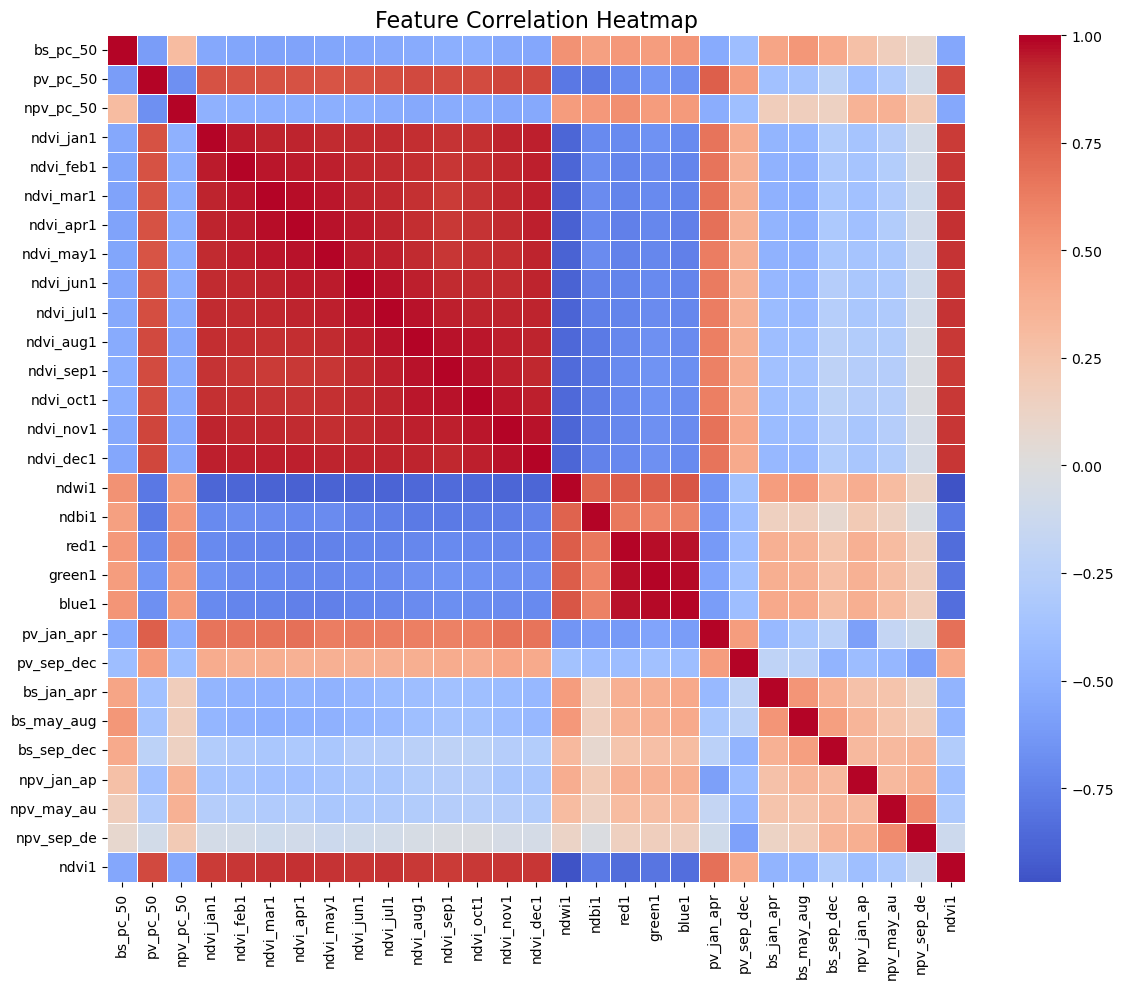

In [10]:
df_features = features
corr_matrix = df_features.corr()

threshold = 0.95
corr_pairs = (
    corr_matrix
    .where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # keep upper triangle
    .stack()  # convert to long format
    .reset_index()
)
corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr = corr_pairs[abs(corr_pairs['Correlation']) > threshold]

print("Highly correlated feature pairs (>|0.95|):")
print(high_corr)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=False,        
    cmap='coolwarm',
    center=0,
    linewidths=0.5
)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

High collinearity between features can negatively impact model performance by introducing redundant information and making the model more sensitive to noise. This can lead to unstable predictions and reduced generalization. However, we chose to retain the monthly NDVI despite its high correlation, as it captures seasonal dynamics, critical for distinguishing land-cover classes such as cropland and forest. Similarly, although RGB bands are highly correlated, each band carries subtle but complementary spectral information that can improve class separability, especially when combined with vegetation and moisture indices.

## 3. Testing and Show Results

In [11]:
test_path = './data/fiji_test.xlsx'
fiji_test = pd.read_excel(test_path)
fiji_test.head()

,fid,class_id,lulc,lon,lat,bs_pc_50,npv_pc_50,pv_pc_50,ndvi1,ndwi1,...,ndvi_mar1,ndvi_apr1,ndvi_may1,ndvi_jun1,ndvi_jul1,ndvi_aug1,ndvi_sep1,ndvi_oct1,ndvi_nov1,ndvi_dec1
0,4884,2,cropland,179.880846,-16.189437,5,25,67,0.687194,-0.666582,...,0.639808,0.711985,0.721354,0.733172,0.697332,0.612364,0.538295,0.608772,0.570598,0.581472
1,4889,3,grassland,179.691789,-16.204109,3,10,92,0.786174,-0.655252,...,0.764901,0.831982,0.825232,0.844361,0.844055,0.715994,0.753183,0.734268,0.760370,0.697904
2,4890,3,grassland,179.868409,-16.201796,4,27,63,0.615594,-0.651147,...,0.551696,0.635145,0.670149,0.672378,0.643348,0.615842,0.527244,0.504229,0.483720,0.519002
3,4891,3,grassland,179.881023,-16.201625,3,8,88,0.784103,-0.682975,...,0.726224,0.814429,0.829746,0.819124,0.798293,0.793655,0.774032,0.763448,0.701912,0.704430
4,4892,1,forest,179.893638,-16.201454,8,8,88,0.881146,-0.780438,...,0.843943,0.851212,0.913334,0.910526,0.907061,0.867796,0.859659,0.871728,0.842921,0.698132


In [12]:
#X_test = fiji_test[['bs_pc_50', 'npv_pc_50', 'pv_pc_50', 'ndvi1', 'ndwi1', 'red1', 'green1', 'blue1', 'texture1', 'ndbi1']] #'nir1', 'savi', 'evi',  'ndbi1', 'ndvi_mean', 'ndvi_std'
#X_test = fiji_test[['bs_pc_50','pv_pc_50','npv_pc_50', 'pv_jan_apr', 'pv_sep_dec', 'ndvi1', 'ndbi1', 'ndwi1', 'red1','green1', 'blue1', 'texture1', 'ndwi1', 'savi']]
X_test = fiji_test[['bs_pc_50','pv_pc_50', 'npv_pc_50', 'ndvi_jan1', 'ndvi_feb1',  'ndvi_mar1', 'ndvi_apr1', 'ndvi_may1','ndvi_jun1','ndvi_jul1','ndvi_aug1','ndvi_sep1', 'ndvi_oct1', 'ndvi_nov1', 'ndvi_dec1',
                'ndwi1', 'ndbi1', 'red1', 'green1', 'blue1', 'pv_jan_apr', 'pv_sep_dec', 'bs_jan_apr', 'bs_may_aug', 'bs_sep_dec', 'npv_jan_ap', 'npv_may_au', 'npv_sep_de', 'ndvi1']]

# Predict classes with trained model
fiji_test['predicted_class'] = rf.predict(X_test)
fiji_test.head()

,fid,class_id,lulc,lon,lat,bs_pc_50,npv_pc_50,pv_pc_50,ndvi1,ndwi1,...,ndvi_apr1,ndvi_may1,ndvi_jun1,ndvi_jul1,ndvi_aug1,ndvi_sep1,ndvi_oct1,ndvi_nov1,ndvi_dec1,predicted_class
0,4884,2,cropland,179.880846,-16.189437,5,25,67,0.687194,-0.666582,...,0.711985,0.721354,0.733172,0.697332,0.612364,0.538295,0.608772,0.570598,0.581472,2
1,4889,3,grassland,179.691789,-16.204109,3,10,92,0.786174,-0.655252,...,0.831982,0.825232,0.844361,0.844055,0.715994,0.753183,0.734268,0.760370,0.697904,3
2,4890,3,grassland,179.868409,-16.201796,4,27,63,0.615594,-0.651147,...,0.635145,0.670149,0.672378,0.643348,0.615842,0.527244,0.504229,0.483720,0.519002,2
3,4891,3,grassland,179.881023,-16.201625,3,8,88,0.784103,-0.682975,...,0.814429,0.829746,0.819124,0.798293,0.793655,0.774032,0.763448,0.701912,0.704430,3
4,4892,1,forest,179.893638,-16.201454,8,8,88,0.881146,-0.780438,...,0.851212,0.913334,0.910526,0.907061,0.867796,0.859659,0.871728,0.842921,0.698132,1


In [13]:
y_true = fiji_test['class_id']
y_pred = fiji_test['predicted_class']

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
kappa = cohen_kappa_score(y_true, y_pred)

print("Test Set Performance")
print(f"Accuracy: {accuracy:.2%}")
print(f"Weighted F1-score: {f1:.2%}")
print(f"Cohen's Kappa: {kappa:.3f}")

from sklearn.metrics import f1_score

labels = np.unique(y_true)

for label in labels:
    mask = y_true == label
    acc_label = (y_pred[mask] == y_true[mask]).mean()
    f1_label = f1_score(y_true, y_pred, labels=[label], average='weighted')
    print(f"Class {label}: Accuracy = {acc_label:.2%}, F1-score = {f1_label:.2%}")

Test Set Performance
Accuracy: 73.22%
Weighted F1-score: 73.17%
Cohen's Kappa: 0.605
Class 1: Accuracy = 83.52%, F1-score = 81.88%
Class 2: Accuracy = 58.56%, F1-score = 51.85%
Class 3: Accuracy = 35.79%, F1-score = 39.31%
Class 4: Accuracy = 25.93%, F1-score = 35.00%
Class 5: Accuracy = 20.00%, F1-score = 9.09%
Class 6: Accuracy = 84.00%, F1-score = 84.00%
Class 7: Accuracy = 86.82%, F1-score = 90.41%


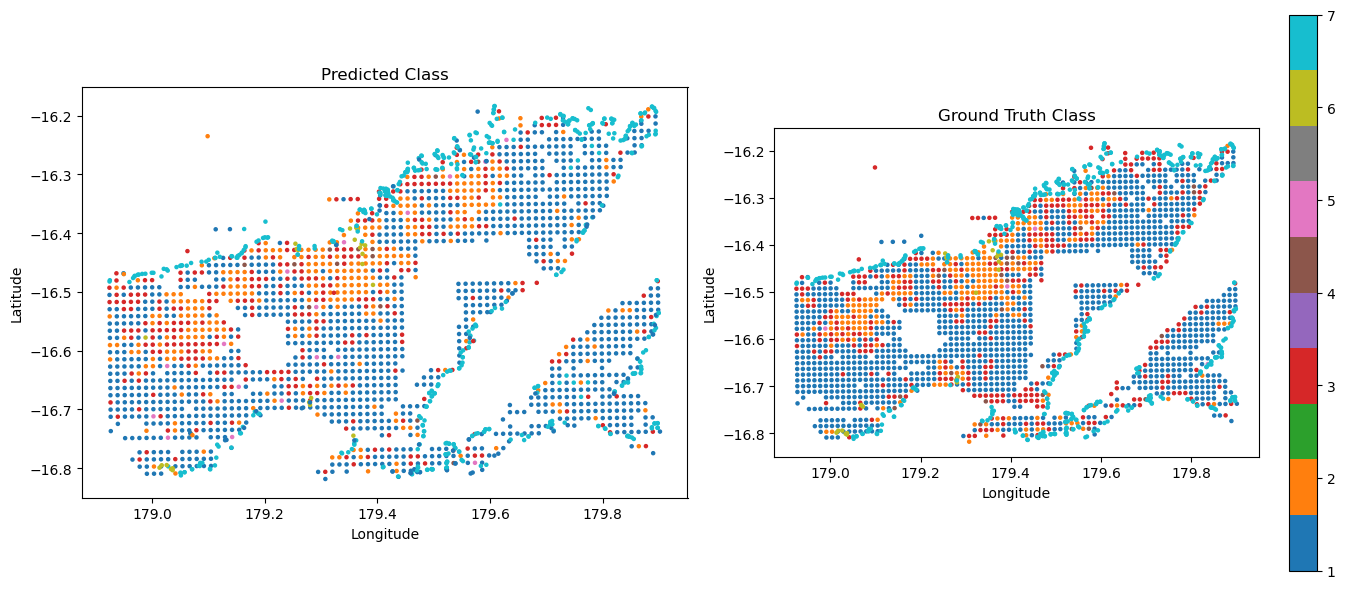

In [14]:
# Plot prediction and groundtruth 
geometry = [Point(xy) for xy in zip(fiji_test['lon'], fiji_test['lat'])]
gdf = gpd.GeoDataFrame(fiji_test, geometry=geometry, crs='EPSG:4326')


fig, axes = plt.subplots(1, 2, figsize=(14, 6))


gdf.plot(column='predicted_class', cmap='tab10', legend=False,
         ax=axes[0], markersize=5)
axes[0].set_title("Predicted Class")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
gdf.plot(column='class_id', cmap='tab10', legend=True,
         ax=axes[1], markersize=5)
axes[1].set_title("Ground Truth Class")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")

plt.tight_layout()
plt.show()

## 4. Comparison with Fractional Cover k-means clustering 

In [120]:
with rasterio.open('bs_pc_50_test.tif') as src:
    bs = src.read(1).astype('float32')
    meta = src.meta

with rasterio.open('pv_pc_50_test.tif') as src:
    pv = src.read(1).astype('float32')

with rasterio.open('npv_pc_50_test.tif') as src:
    npv = src.read(1).astype('float32')

def normalize_band(band, scale=255):
    return np.clip(band / scale, 0, 1)

bs_norm = normalize_band(bs, 255)
pv_norm = normalize_band(pv, 255)
npv_norm = normalize_band(npv, 255)

#  Stack into RGB 
rgb = np.dstack((bs_norm, pv_norm, npv_norm))
rgb = np.clip(rgb, 0, 1)


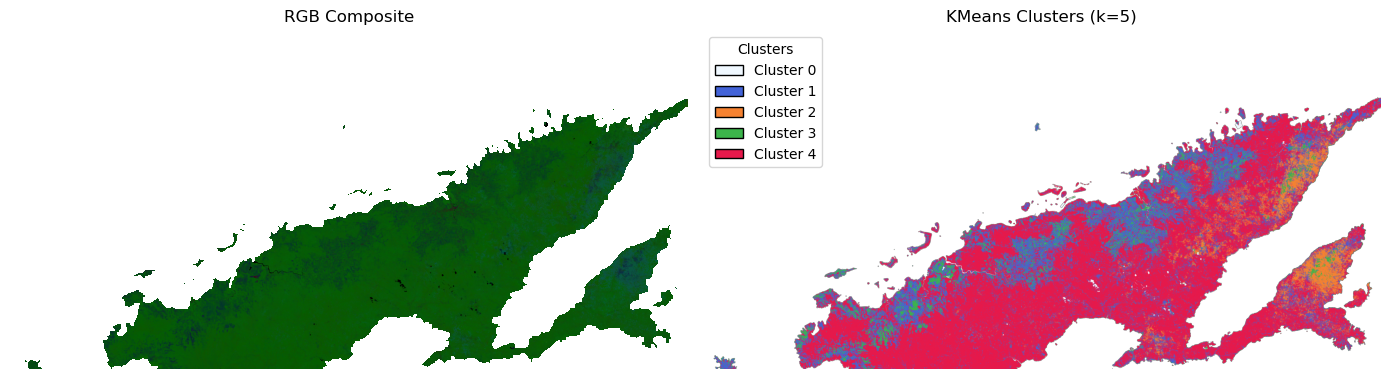

In [121]:
k = 5
h, w, c = rgb.shape

# Prepare Data for Clustering 
flat_rgb = rgb.reshape(-1, 3)
valid_mask = ~np.isnan(flat_rgb).any(axis=1)
rgb_valid = flat_rgb[valid_mask]

# KMeans Clustering
kmeans = KMeans(n_clusters=k, random_state=42)
labels = np.full(flat_rgb.shape[0], np.nan)
labels[valid_mask] = kmeans.fit_predict(rgb_valid)
label_img = labels.reshape(h, w)

# Plot RGB and Cluster Image 
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(rgb)
axes[0].set_title("RGB Composite")
axes[0].axis('off')

fixed_colors = [
    'aliceblue', '#4363d8', '#f58231', '#3cb44b', '#e6194b',
    '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe'
]
cluster_cmap = ListedColormap(fixed_colors[:k])

axes[1].imshow(label_img, cmap=cluster_cmap)
axes[1].set_title(f'KMeans Clusters (k={k})')
axes[1].axis('off')

legend_elements = [
    Patch(facecolor=cluster_cmap(i), edgecolor='black', label=f'Cluster {i}')
    for i in range(k)
]
axes[1].legend(handles=legend_elements, loc='upper left', title='Clusters')
plt.tight_layout()
plt.show()


## 5. Prepare FC Temporal Data

In [19]:
import sys
from pystac_client import Client
import depal_ck as dep
from odc.stac import load
from shapely import geometry
import geopandas as gpd
import rioxarray
from dea_tools.dask import create_local_dask_cluster

client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/philippinel@spc.int/proxy/8787/status,
Dashboard: /user/philippinel@spc.int/proxy/8787/status,Workers: 1
Total threads: 8,Total memory: 57.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34245,Workers: 0
Dashboard: /user/philippinel@spc.int/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:43971,Total threads: 8
Dashboard: /user/philippinel@spc.int/proxy/35711/status,Memory: 57.21 GiB
Nanny: tcp://127.0.0.1:46701,


In [20]:
catalog = "https://stac.staging.digitalearthpacific.io"
client = Client.open(catalog)
collections = client.get_collections()

In [57]:
fj = dep.get_country_admin_boundary('Fiji', 'Division', "Central")

# uncomment for dowloading testing seasonal fc 
#fj = dep.get_country_admin_boundary('New Caledonia', 'Commune', "Nouméa")

#fj = dep.get_country_boundary('Palau')
bbox = dep.get_bbox(fj)
bbox_geometry = geometry.box(*bbox)

gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')
gdf.explore()

In [ ]:
# List of Palau states
"""
states = [
    "Aimeliik",
    "Airai",
    "Koror",
    "Melekeok",
    "Ngaraard",
    "Ngardmau",
    "Ngatpang",
    "Ngchesar",
    "Ngeremlengui",
    "Ngiwal"
]
"""
# for fiji test state 
states = ['Cakaudrove', 'Macuata']


gdfs = [dep.get_country_admin_boundary('Fiji', 'Province', state) for state in states]
# Concatenate into a single GeoDataFrame
fj = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)


bbox = dep.get_bbox(fj)
bbox = list(bbox)

# uncomment for fiji test
bbox[0] = 178.70143044283932
bbox[2] = 179.95873926040082

bbox_geometry = geometry.box(*bbox)


gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')
gdf.explore()

### Mask the cloud using other landsat-8 images

To remove cloud-contaminated pixels from the Fractional Cover (FC) dataset, we used the WOFL (Water Observations from Landsat) data, which is derived from the same Landsat-8 imagery. In this dataset, cloud pixels are labeled with the value 1. We applied this cloud mask to exclude those pixels from the FC data, paying attention to match the date between both images.

In [72]:
# WOFL Landsat-8 Image --> USED AS THE MASK
items = client.search(collections=["dep_ls_wofl"], bbox=bbox, datetime="2024-01-01/2024-04-30").item_collection()

items = client.search(
    collections=["dep_ls_wofl"],
    bbox=bbox,
    datetime="2024-01-01/2024-04-30",
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data_temoin = load(items, chunks=chunks)
data_temoin = dep.do_coastal_clip(fj, data_temoin , buffer=0.001)
print(data_temoin)

<xarray.Dataset> Size: 16MB
Dimensions:      (y: 474, x: 742, time: 45)
Coordinates:
  * y            (y) float64 4kB -2.457e+06 -2.457e+06 ... -2.471e+06 -2.471e+06
  * x            (x) float64 6kB 6.33e+05 6.331e+05 ... 6.552e+05 6.553e+05
  * time         (time) datetime64[ns] 360B 2024-01-03T22:57:20.821440 ... 20...
    spatial_ref  int64 8B 0
Data variables:
    water        (time, y, x) uint8 16MB dask.array<chunksize=(1, 266, 742), meta=np.ndarray>


In [73]:
# FC Landsat-8 Image 
items = client.search(
    collections=["dep_ls_fc"],
    bbox=bbox,
    datetime="2024-01-01/2024-04-30",
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data = load(items, chunks=chunks)
data = dep.do_coastal_clip(fj, data, buffer=0.001)
print(data)

<xarray.Dataset> Size: 63MB
Dimensions:      (y: 474, x: 742, time: 45)
Coordinates:
  * y            (y) float64 4kB -2.457e+06 -2.457e+06 ... -2.471e+06 -2.471e+06
  * x            (x) float64 6kB 6.33e+05 6.331e+05 ... 6.552e+05 6.553e+05
  * time         (time) datetime64[ns] 360B 2024-01-03T22:57:20.821440 ... 20...
    spatial_ref  int64 8B 0
Data variables:
    bs           (time, y, x) uint8 16MB dask.array<chunksize=(1, 266, 742), meta=np.ndarray>
    pv           (time, y, x) uint8 16MB dask.array<chunksize=(1, 266, 742), meta=np.ndarray>
    ue           (time, y, x) uint8 16MB dask.array<chunksize=(1, 266, 742), meta=np.ndarray>
    npv          (time, y, x) uint8 16MB dask.array<chunksize=(1, 266, 742), meta=np.ndarray>


In [74]:
# Extract just the dates (YYYY-MM-DD)
data_dates = pd.to_datetime(data.time.values).normalize()
temoin_dates = pd.to_datetime(data_temoin.time.values).normalize()

# Build index mapping by date 
data_idx = {d: i for i, d in enumerate(data_dates)}
temoin_idx = {d: j for j, d in enumerate(temoin_dates)}

# Find common dates
common_dates = sorted(set(data_idx.keys()) & set(temoin_idx.keys()))

# Initialize masked copy
data_masked = data.copy()

# Loop over matching dates
for date in common_dates:
    
    i = data_idx[date]
    j = temoin_idx[date]
    mask = data_temoin['water'].isel(time=j) == 1

    for band in ['bs', 'pv', 'npv']:
        
        band_slice = data[band].isel(time=i)
        mask_aligned = mask.broadcast_like(band_slice)
        masked_slice = band_slice.where(~mask_aligned, 255)
        data_masked[band][i] = masked_slice

In [ ]:
def plot_median_fc_bands_and_rgb(data_masked):
    """
    Compute median over time for bs, pv, npv bands in a masked dataset,
    then plot each band + RGB composite (R=bs, G=pv, B=npv).
    """
    clean = data_masked.where(data_masked != 255)
    median_ds = clean.median(dim="time", skipna=True)

    #  Extract median bands
    bs  = median_ds['bs'].values
    pv  = median_ds['pv'].values
    npv = median_ds['npv'].values

    # Normalize to [0, 1] range
    rgb = np.stack([bs, pv, npv], axis=-1).astype(np.float32)
    rgb = rgb / 255.0

    # Plot
    fig, axs = plt.subplots(1, 4, figsize=(20, 6))

    axs[0].imshow(bs, cmap='gray')
    axs[0].set_title("Median BS (Bare Soil)")
    axs[0].axis('off')

    axs[1].imshow(pv, cmap='gray')
    axs[1].set_title("Median PV (Green)")
    axs[1].axis('off')

    axs[2].imshow(npv, cmap='gray')
    axs[2].set_title("Median NPV (Brown)")
    axs[2].axis('off')

    axs[3].imshow(rgb)
    axs[3].set_title("Median RGB Composite\nR=BS, G=PV, B=NPV")
    axs[3].axis('off')

    plt.tight_layout()
    plt.show()


plot_median_fc_bands_and_rgb(data_masked)

In [35]:
# Compute the median
clean = data_masked.where(data_masked != 255)
median_ds = clean.median(dim="time", skipna=True)

bs_median  = median_ds['bs']
pv_median  = median_ds['pv']
npv_median = median_ds['npv']

# Stack into xarray 
bands = xr.concat([bs_median, pv_median, npv_median], dim="band")
bands = bands.assign_coords(band=["bs", "pv", "npv"])

# Set CRS and export as GeoTIFF
# Fiji -> EPSG : 32660 ; Marshall -> EPSG : 32659 ; Cook -> EPSG : 32604 ; Palaos -> EPSG : 32653
bands.rio.write_crs("EPSG:32660", inplace=True) 
bands.rio.to_raster("fc_fijitest_jan_apr.tif")


In [76]:
# Save testing data
clean = data_masked.where(data_masked != 255)
median_ds = clean.median(dim="time", skipna=True)

bs_median  = median_ds['bs']
pv_median  = median_ds['pv']
npv_median = median_ds['npv']

# Output folder
os.makedirs("./test", exist_ok=True)

# Save each median band separately
for var, name in zip([bs_median, pv_median, npv_median], ["bs", "pv", "npv"]):
    var.rio.write_crs("EPSG:32658", inplace=True)
    var.rio.to_raster(f"./test/{name}_jan_apr.tif")

## 6. Test RF Classifier on Image 

In this part, we prepare and stack all the bands FC and Spectral Images to test the RF classifier on an image

### Prepare raster bands :

In [36]:
aoi = dep.get_country_admin_boundary('New Caledonia', 'Commune', "Nouméa")
bbox = dep.get_bbox(aoi)
bbox_geometry = geometry.box(*bbox)
gdf = gpd.GeoDataFrame({'geometry': [bbox_geometry]}, crs='EPSG:4326')
gdf.explore()

In [21]:
# Annual bs, pv, npv data 
items = client.search(
    collections=["dep_ls_fc_summary_annual"],
    bbox=bbox,
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data = load(items, chunks=chunks)
data = dep.do_coastal_clip(aoi, data, buffer=0.001)

vars_to_save = ["bs_pc_50", "pv_pc_50", "npv_pc_50"]
os.makedirs("./test", exist_ok=True)
for var in vars_to_save:
    data[var].rio.write_crs("EPSG:3832").rio.to_raster(f"./test/{var}.tif")

In [17]:
# annual RGB-NIR-SWIR, NDVI, NDWI, NDBI, EVI 
items = client.search(
    collections=["dep_s2_geomad"],
    bbox=bbox,
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data = load(items, chunks=chunks)
data = dep.do_coastal_clip(aoi, data, buffer=0.001)

ds_2024 = data.sel(time="2024-01-01")

os.makedirs("./test", exist_ok=True)


for band in ["red", "green", "blue"]:
    ds_2024[band].rio.write_crs("EPSG:3832").rio.to_raster(f"./test/{band}1.tif")

red = ds_2024["red"].astype("float32")
green = ds_2024["green"].astype("float32")
blue = ds_2024["blue"].astype("float32")
nir = ds_2024["nir"].astype("float32")
swir16 = ds_2024["swir16"].astype("float32")

# NDVI = (NIR - RED) / (NIR + RED)
ndvi = (nir - red) / (nir + red)

# NDWI (McFeeters 1996) = (GREEN - NIR) / (GREEN + NIR)
ndwi = (green - nir) / (green + nir)

# EVI = 2.5 * (NIR - RED) / (NIR + 6*RED - 7.5*BLUE + 1)
evi = 2.5 * (nir - red) / (nir + 6*red - 7.5*blue + 1)

# NDBI = (SWIR - NIR) / (SWIR + NIR)
ndbi = (swir16 - nir) / (swir16 + nir)

ndvi.rio.write_crs("EPSG:3832").rio.to_raster("./test/ndvi1.tif")
ndwi.rio.write_crs("EPSG:3832").rio.to_raster("./test/ndwi1.tif")
evi.rio.write_crs("EPSG:3832").rio.to_raster("./test/evi1.tif")
ndbi.rio.write_crs("EPSG:3832").rio.to_raster("./test/ndbi1.tif")

<xarray.Dataset> Size: 419MB
Dimensions:      (y: 1532, x: 2401, time: 3)
Coordinates:
  * y            (y) float64 12kB -2.521e+06 -2.521e+06 ... -2.536e+06
  * x            (x) float64 19kB 1.814e+06 1.814e+06 ... 1.838e+06 1.838e+06
  * time         (time) datetime64[ns] 24B 2022-01-01 2023-01-01 2024-01-01
    spatial_ref  int64 8B 0
Data variables: (12/16)
    nir          (time, y, x) uint16 22MB dask.array<chunksize=(1, 493, 694), meta=np.ndarray>
    red          (time, y, x) uint16 22MB dask.array<chunksize=(1, 493, 694), meta=np.ndarray>
    blue         (time, y, x) uint16 22MB dask.array<chunksize=(1, 493, 694), meta=np.ndarray>
    emad         (time, y, x) float32 44MB dask.array<chunksize=(1, 493, 694), meta=np.ndarray>
    smad         (time, y, x) float32 44MB dask.array<chunksize=(1, 493, 694), meta=np.ndarray>
    bcmad        (time, y, x) float32 44MB dask.array<chunksize=(1, 493, 694), meta=np.ndarray>
    ...           ...
    swir16       (time, y, x) uint16 22MB

In [51]:
# montlhy ndvi (reproject)

ndvi_files = sorted(glob.glob("./test/ndvi_*.tif"))
target_crs = "EPSG:3832"
for f in ndvi_files:
    # Open raster
    da = rioxarray.open_rasterio(f, masked=False)

    # Count NaN pixels
    nan_count = da.isnull().sum().item()

    # reproject to EPSG : 3832
    da = da.rio.reproject(target_crs)

    # Save raster with NaN encoded as NoData
    da.rio.write_nodata(None, encoded=True)
    da.rio.to_raster(f)

./test/ndvi_apr1.tif: 316638 pixels with NaN
./test/ndvi_aug1.tif: 316634 pixels with NaN
./test/ndvi_dec1.tif: 316643 pixels with NaN
./test/ndvi_feb1.tif: 316637 pixels with NaN
./test/ndvi_jan1.tif: 316638 pixels with NaN
./test/ndvi_jul1.tif: 316634 pixels with NaN
./test/ndvi_jun1.tif: 316640 pixels with NaN
./test/ndvi_mar1.tif: 316639 pixels with NaN
./test/ndvi_may1.tif: 316641 pixels with NaN
./test/ndvi_nov1.tif: 316639 pixels with NaN
./test/ndvi_oct1.tif: 316637 pixels with NaN
./test/ndvi_sep1.tif: 316641 pixels with NaN


In [16]:
# bands do not have the exact same shape,need to align them on a reference image
import rioxarray
target_crs = "EPSG:3832"
folder = "./test"
features = [
    'bs_pc_50','pv_pc_50','npv_pc_50',
    'ndvi_jan1','ndvi_feb1','ndvi_mar1','ndvi_apr1','ndvi_may1','ndvi_jun1',
    'ndvi_jul1','ndvi_aug1','ndvi_sep1','ndvi_oct1','ndvi_nov1','ndvi_dec1',
    'ndwi1','ndbi1','red1','green1','blue1',
    'pv_jan_apr','pv_sep_dec','bs_jan_apr','bs_may_aug','bs_sep_dec',
    'npv_jan_ap','npv_may_au','npv_sep_de','ndvi1'
]

ref_path = os.path.join(folder, "bs_pc_50.tif")
ref_da = rioxarray.open_rasterio(ref_path, masked=True)

# Ensure reference is in the target CRS
if ref_da.rio.crs != target_crs:
    ref_da = ref_da.rio.reproject(target_crs)

data_arrays = []
for feat in features:
    path = os.path.join(folder, f"{feat}.tif")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file: {path}")

    da = rioxarray.open_rasterio(path, masked=True)

    # Reproject to reference grid (CRS + resolution + alignment)
    da = da.rio.reproject_match(ref_da)

    data_arrays.append(da)

# Stack aligned rasters
stacked = xr.concat(data_arrays, dim="band")
stacked = stacked.assign_coords(band=features)

/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/tmp/ipykernel_562/4055617634.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = ListedColormap(plt.cm.get_cmap('tab20', num_classes).colors)


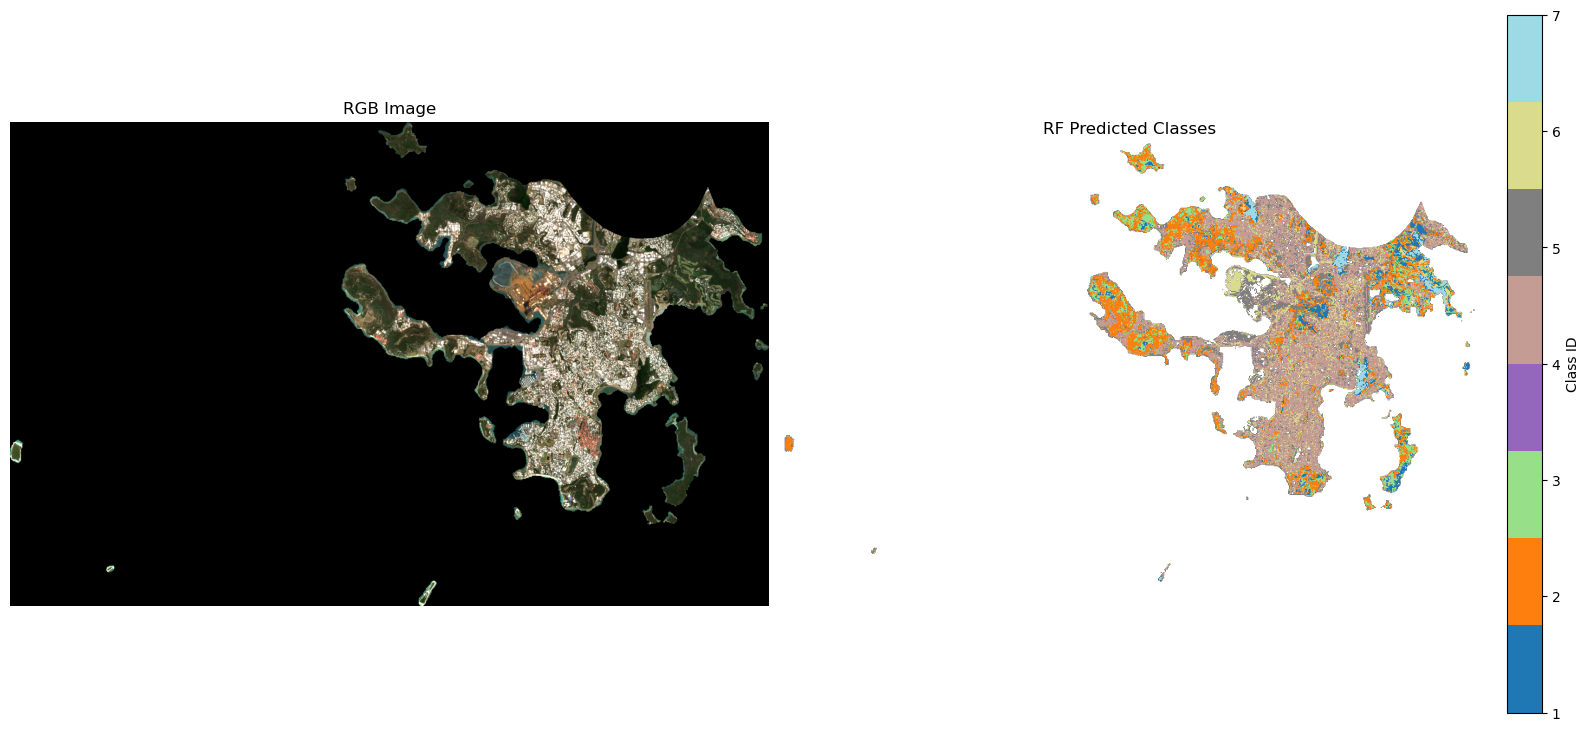

In [17]:
bands, ysize, xsize = stacked.shape

# Flatten to (pixels, features)
X_test = stacked.values.reshape(bands, -1).T  

# Select only valid pixels
valid_mask = np.all(np.isfinite(X_test), axis=1)
X_valid = X_test[valid_mask]

# Predict only on valid pixels
pred_flat = np.full(X_test.shape[0], np.nan)  # initialize with NaN
pred_flat[valid_mask] = rf.predict(X_valid)

# Reshape back to raster
pred_raster = pred_flat.reshape(ysize, xsize)

# Load RGB for plotting
red = rioxarray.open_rasterio("./test/red1.tif")[0].values
green = rioxarray.open_rasterio("./test/green1.tif")[0].values
blue = rioxarray.open_rasterio("./test/blue1.tif")[0].values

rgb = np.stack([red, green, blue], axis=-1)
rgb_norm = np.clip(rgb / np.percentile(rgb, 99), 0, 1)

# Colormap for classes
num_classes = int(np.nanmax(pred_raster)) + 1
cmap = ListedColormap(plt.cm.get_cmap('tab20', num_classes).colors)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(rgb_norm)
axes[0].set_title("RGB Image")
axes[0].axis('off')

im = axes[1].imshow(pred_raster, cmap=cmap)
axes[1].set_title("RF Predicted Classes")
axes[1].axis('off')
fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04, label='Class ID')

plt.tight_layout()
plt.show()


pb : lot of forest classified as cropland 

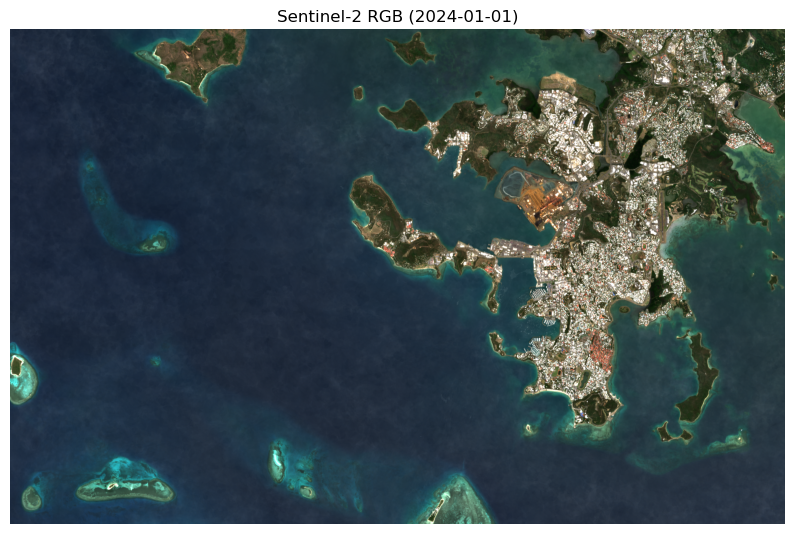

In [57]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# annual RGB-NIR-SWIR, NDVI, NDWI, NDBI, EVI 
items = client.search(
    collections=["dep_s2_geomad"],
    bbox=bbox,
).items()
chunks = dict(x=2048, y=2048)

# Load the data
data = load(items, chunks=chunks) 
data = data.rio.write_crs("EPSG:3832")
data = data.sel(time="2024-01-01")

# Ensure CRS matches
aoi = aoi.to_crs("EPSG:3832")

# Crop to AOI bounding box (but keep water!)
data_cropped = data.rio.clip_box(
    minx=aoi.total_bounds[0],
    miny=aoi.total_bounds[1],
    maxx=aoi.total_bounds[2],
    maxy=aoi.total_bounds[3],
)

red = data_cropped["red"].astype("float32").values
green = data_cropped["green"].astype("float32").values
blue = data_cropped["blue"].astype("float32").values

rgb = np.stack([red, green, blue], axis=-1)
rgb_norm = np.clip(rgb / np.percentile(rgb, 99), 0, 1)


# Plot RGB
plt.figure(figsize=(10, 10))
plt.imshow(rgb_norm)
plt.axis("off")
plt.title("Sentinel-2 RGB (2024-01-01)")
plt.show()

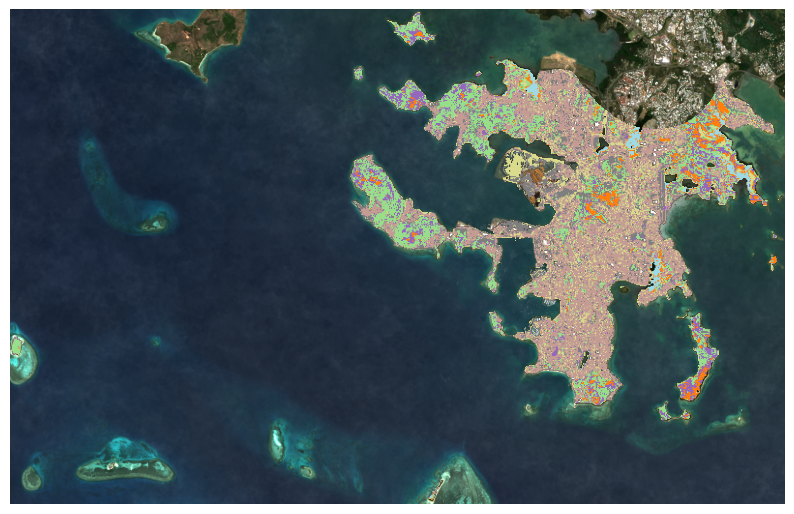

In [60]:
# --- Prediction raster ---
num_classes = int(np.nanmax(pred_raster)) + 1
cmap = ListedColormap(plt.cm.get_cmap('tab20', num_classes).colors)
bounds = np.arange(num_classes+1) - 0.5
norm = BoundaryNorm(bounds, cmap.N)

# --- Plot ---
extent = [0, rgb_norm.shape[1], rgb_norm.shape[0], 0]

fig, ax = plt.subplots(figsize=(10, 10))

# Background
ax.imshow(rgb_norm, extent=extent)

# Overlay (with same extent!)
ax.imshow(pred_raster, cmap=cmap, norm=norm, alpha=1, extent=extent)

ax.axis("off")
plt.savefig("prediction.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()